This cell verifies that a CUDA-enabled GPU is available in the runtime.
`torch.cuda.is_available()` checks PyTorch GPU support,
while `nvidia-smi` prints hardware details and current GPU utilization,
ensuring the environment is properly configured for accelerated training.

In [48]:
# Check GPU
import torch
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi


CUDA available: True
Thu Dec  4 22:28:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             59W /  400W |    2279MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+--------------------------

Mount Google Drive
This mounts the user's Google Drive into the Colab filesystem so that
datasets, trained model checkpoints, and logs can be read from and
saved directly to persistent storage (e.g., /content/drive/MyDrive).
This prevents losing files when the Colab runtime resets.

In [49]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This cell installs all required Python libraries used in the pipeline:

torch, torchvision – deep learning framework and model zoo (RetinaNet, SSD).

pycocotools – official COCO evaluation toolkit for computing AP/AR metrics.

pillow – image loading and preprocessing.

pandas – log parsing and tabular analysis.

tqdm – progress bars during training.

matplotlib, seaborn – plotting training curves and metrics.

albumentations – advanced data augmentation (used for future enhancement).

In [50]:
%cd /content/

!pip install torch torchvision pycocotools pillow pandas tqdm matplotlib seaborn albumentations==1.4.0


/content


This command extracts the Stanford Dogs dataset from Google Drive into the Colab workspace.
The dataset contains:

Images/ — breed-organized dog images.

Annotation/ — XML bounding-box labels for each image.

After extraction, these files are used by the custom XML→COCO conversion script and dataset loaders for training RetinaNet and SSD.

In [51]:
!unzip "/content/drive/MyDrive/ML_datasets/StanfordDogs.zip" -d /content/dogs/


Archive:  /content/drive/MyDrive/ML_datasets/StanfordDogs.zip
replace /content/dogs/StanfordDogs/Annotation/n02085620-Chihuahua/n02085620_10074? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This cell verifies the dataset structure after extraction:

Images/ contains dog images organized by breed folders.

Annotation/ contains corresponding XML bounding-box annotation files.

In [52]:
!ls /content/dogs/StanfordDogs/Images/
!ls /content/dogs/StanfordDogs/Annotation/

n02085620-Chihuahua			  n02100583-vizsla
n02085782-Japanese_spaniel		  n02100735-English_setter
n02085936-Maltese_dog			  n02100877-Irish_setter
n02086079-Pekinese			  n02101006-Gordon_setter
n02086240-Shih-Tzu			  n02101388-Brittany_spaniel
n02086646-Blenheim_spaniel		  n02101556-clumber
n02086910-papillon			  n02102040-English_springer
n02087046-toy_terrier			  n02102177-Welsh_springer_spaniel
n02087394-Rhodesian_ridgeback		  n02102318-cocker_spaniel
n02088094-Afghan_hound			  n02102480-Sussex_spaniel
n02088238-basset			  n02102973-Irish_water_spaniel
n02088364-beagle			  n02104029-kuvasz
n02088466-bloodhound			  n02104365-schipperke
n02088632-bluetick			  n02105056-groenendael
n02089078-black-and-tan_coonhound	  n02105162-malinois
n02089867-Walker_hound			  n02105251-briard
n02089973-English_foxhound		  n02105412-kelpie
n02090379-redbone			  n02105505-komondor
n02090622-borzoi			  n02105641-Old_English_sheepdog
n02090721-Irish_wolfhound		  n02105855-Shetland_sheepdog
n02091032-Itali

This cell generates all core training and evaluation scripts used in the project.
The scripts collectively implement the full RetinaNet detection pipeline on
the Stanford Dogs dataset, including:
1) XML → COCO conversion to enable compatibility with PyTorch detection APIs.
2) Dataset splitting into training and validation partitions.
3) Custom COCO Dataset loader for reading images and bounding-box labels.
4) Logging and reproducibility utilities (CSV logger and seed control).
5) A plotting script that converts training logs into publication-ready
   PDF visualizations (overall loss curve and smoothed classification vs.
   regression losses).
 This cell programmatically writes all scripts to disk so they can be executed
 independently during dataset preparation, training, evaluation, and reporting.

In [53]:
# --- WRITE ALL SCRIPTS ---

scripts = {

# -----------------------------------------------------------
# 1) convert_to_coco.py  (your final, png+jpg aware version)
# -----------------------------------------------------------
"convert_to_coco.py": r'''
import os, json, xml.etree.ElementTree as ET
from tqdm import tqdm

def convert(images_dir, annot_dir, out_json):
    breeds = sorted([d for d in os.listdir(annot_dir) if os.path.isdir(os.path.join(annot_dir, d))])
    categories = [{"id": i + 1, "name": b} for i, b in enumerate(breeds)]
    breed_to_id = {b: i + 1 for i, b in enumerate(breeds)}

    coco = {"images": [], "annotations": [], "categories": categories}
    ann_id = 1; img_id = 1

    for breed in tqdm(breeds, desc="Breeds"):
        ann_folder = os.path.join(annot_dir, breed)
        img_folder = os.path.join(images_dir, breed)

        for xml_file in sorted(os.listdir(ann_folder)):
            xml_path = os.path.join(ann_folder, xml_file)
            if not os.path.isfile(xml_path):
                continue

            root = ET.parse(xml_path).getroot()

            filename_node = root.find("filename")
            filename = filename_node.text if filename_node is not None else xml_file.replace(".xml","")

            # support both jpg and png
            img_path = None
            for ext in [".jpg",".jpeg",".png"]:
                test = os.path.join(img_folder, filename.replace(".xml","") + ext)
                if os.path.exists(test):
                    img_path = test
                    filename = os.path.basename(test)
                    break

            if img_path is None:
                print(f"Missing image for {xml_file}")
                continue

            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            coco["images"].append({
                "id": img_id,
                "file_name": f"{breed}/{filename}",
                "width": width, "height": height
            })

            for obj in root.findall("object"):
                bbox = obj.find("bndbox")
                xmin = int(float(bbox.find("xmin").text))
                ymin = int(float(bbox.find("ymin").text))
                xmax = int(float(bbox.find("xmax").text))
                ymax = int(float(bbox.find("ymax").text))
                w, h = xmax - xmin, ymax - ymin

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "bbox": [xmin, ymin, w, h],
                    "category_id": breed_to_id[breed],
                    "iscrowd": 0,
                    "area": w * h
                })
                ann_id += 1

            img_id += 1

    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(coco, f, indent=2)

    print("Saved COCO ->", out_json)
    print("Images:", len(coco["images"]), "Annotations:", len(coco["annotations"]))

if __name__ == "__main__":
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--images_dir")
    ap.add_argument("--annot_dir")
    ap.add_argument("--out_json")
    args = ap.parse_args()
    convert(args.images_dir, args.annot_dir, args.out_json)
''',

# -----------------------------------------------------------
# 2) split_train_val.py
# -----------------------------------------------------------
"split_train_val.py": r'''
import json, random, os

def split(json_in, train_out, val_out, ratio=0.9):
    with open(json_in,"r",encoding="utf-8") as f:
        coco=json.load(f)
    ids=[im["id"] for im in coco["images"]]
    random.shuffle(ids)
    cut=int(len(ids)*ratio)
    train_ids=set(ids[:cut])
    val_ids=set(ids[cut:])

    def subset(sel):
        return {
            "images":[im for im in coco["images"] if im["id"] in sel],
            "annotations":[a for a in coco["annotations"] if a["image_id"] in sel],
            "categories": coco["categories"]
        }

    os.makedirs(os.path.dirname(train_out),exist_ok=True)
    with open(train_out,"w") as f: json.dump(subset(train_ids),f)
    with open(val_out,"w") as f: json.dump(subset(val_ids),f)
    print("Train:",len(train_ids),"Val:",len(val_ids))

if __name__ == "__main__":
    import argparse
    ap=argparse.ArgumentParser()
    ap.add_argument("--json_in")
    ap.add_argument("--train_out")
    ap.add_argument("--val_out")
    ap.add_argument("--ratio",type=float,default=0.9)
    args=ap.parse_args()
    split(args.json_in,args.train_out,args.val_out,args.ratio)
''',

# -----------------------------------------------------------
# 3) dogs_coco_dataset.py
# -----------------------------------------------------------
"dogs_coco_dataset.py": r'''
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import os

class DogsCocoDet(Dataset):
    def __init__(self, images_dir, ann_file):
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())
        self.images_dir = images_dir

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.images_dir, info["file_name"])
        img = Image.open(path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        boxes=[]
        labels=[]
        for a in anns:
            x,y,w,h = a["bbox"]
            boxes.append([x,y,x+w,y+h])
            labels.append(a["category_id"])

        target={
            "boxes": torch.tensor(boxes,dtype=torch.float32),
            "labels": torch.tensor(labels,dtype=torch.int64),
            "image_id": torch.tensor([img_id])
        }
        return F.to_tensor(img), target

def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)
''',

# -----------------------------------------------------------
# 4) utils_det.py  (logging + seeding)
# -----------------------------------------------------------
"utils_det.py": r'''
import os, csv, time, random, numpy as np, torch

class CSVLogger:
    def __init__(self, path, fieldnames):
        self.path = path
        os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
        self.fieldnames = ["time","epoch","iter"] + list(fieldnames)
        if not os.path.exists(path):
            with open(path, "w", newline="", encoding="utf-8") as f:
                csv.DictWriter(f, fieldnames=self.fieldnames).writeheader()

    def log(self, epoch, it, **kw):
        row = {"time": time.time(), "epoch": epoch, "iter": it}
        for k in self.fieldnames:
            if k in kw:
                row[k] = kw[k]
        with open(self.path, "a", newline="", encoding="utf-8") as f:
            csv.DictWriter(f, fieldnames=self.fieldnames).writerow(row)

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
''',

# -----------------------------------------------------------
# 5) plot_logs.py  (CSV → plots)
# -----------------------------------------------------------
"plot_logs.py": r'''
import argparse, pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def main(args):
    os.makedirs(os.path.dirname(args.loss_pdf) or ".", exist_ok=True)
    df = pd.read_csv(args.csv)

    # Loss curve
    plt.figure()
    df["loss"].plot()
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig(args.loss_pdf)
    plt.close()

    # Classification / bbox loss
    plt.figure()
    df["classification"].rolling(50).mean().plot(label="cls (smoothed)")
    df["bbox_regression"].rolling(50).mean().plot(label="bbox (smoothed)")
    plt.legend()
    plt.title("Classification vs BBox Loss (smoothed)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig(args.loss_components_pdf)
    plt.close()

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--csv", default="logs/train.csv")
    ap.add_argument("--loss_pdf", default="plots/loss.pdf")
    ap.add_argument("--loss_components_pdf", default="plots/loss_components.pdf")
    args = ap.parse_args()
    main(args)
''',
}

for name, code in scripts.items():
    with open(name, "w") as f:
        f.write(code)

print("✅ All scripts written successfully!")


✅ All scripts written successfully!


This cell converts the original PASCAL-VOC XML annotations of the Stanford Dogs dataset into the COCO JSON format required by the PyTorch detection models. It scans all breed folders, matches each XML file with its corresponding image (PNG or JPG), extracts bounding boxes and labels, and saves a single consolidated annotations file (annotations.json) for later train/validation splitting and model training.

In [54]:
!python convert_to_coco.py \
  --images_dir /content/dogs/StanfordDogs/Images \
  --annot_dir  /content/dogs/StanfordDogs/Annotation \
  --out_json   /content/annotations.json


Breeds:   8% 9/120 [00:00<00:01, 87.50it/s]Missing image for n02089973_1
Missing image for n02089973_1000
Missing image for n02089973_1030
Missing image for n02089973_1066
Missing image for n02089973_1076
Missing image for n02089973_1078
Missing image for n02089973_1106
Missing image for n02089973_1132
Missing image for n02089973_1232
Missing image for n02089973_1249
Missing image for n02089973_1255
Missing image for n02089973_1260
Missing image for n02089973_1277
Missing image for n02089973_1298
Missing image for n02089973_1303
Missing image for n02089973_1312
Missing image for n02089973_1324
Missing image for n02089973_1345
Missing image for n02089973_1352
Missing image for n02089973_1356
Missing image for n02089973_1357
Missing image for n02089973_1375
Missing image for n02089973_1381
Missing image for n02089973_140
Missing image for n02089973_1458
Missing image for n02089973_1490
Missing image for n02089973_1492
Missing image for n02089973_1516
Missing image for n02089973_1577
Miss

Randomly splits the COCO annotations into 90% training and 10% validation subsets, producing separate JSON files for model training and evaluation.

In [56]:
!python split_train_val.py \
  --json_in /content/annotations.json \
  --train_out /content/train.json \
  --val_out   /content/val.json \
  --ratio 0.9


Train: 17960 Val: 1996


Confirms that image files are correctly located inside breed-specific folders
 and ensures the file paths required by the COCO annotations are valid.

In [57]:
!ls /content/dogs/StanfordDogs/Images | head
!find /content/dogs/StanfordDogs/Images -maxdepth 2 -type f | head


n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_5450.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_1760.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_2366.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_4270.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_1753.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_6295.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_1330.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_2179.jpg
/content/dogs/StanfordDogs/Images/n02091467-Norwegian_elkhound/n02091467_1961.jpg
/content/dogs/StanfordDogs/Images/

5) A complete SSD training script with:
     - a VGG16 backbone trained from scratch (no pretrained detection weights)
     - mixed-precision training (AMP) for GPU acceleration,
     - gradient clipping for numerical stability,
     - Cosine Annealing learning-rate scheduling,
     - per-iteration CSV logging of classification loss, box regression loss,
        and total loss,
     - per-epoch checkpoint saving.

In [58]:
# ==========================================================
# train_ssd.py   (Stable AMP + logging + clipping SSD setup)
# ==========================================================

import torch, torchvision, csv, os, time
from dogs_coco_dataset import DogsCocoDet, collate_fn
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
IMAGES = "/content/dogs/StanfordDogs/Images"
TRAIN_JSON = "/content/train.json"
EPOCHS = 25
BATCH_SIZE = 6
LR = 1e-4
WEIGHTS_OUT = "ssd_dogs.pth"
LOG_CSV = "logs/ssd_train.csv"

NUM_CLASSES = 121
CLIP_NORM = 5.0

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE =", DEVICE)

os.makedirs("logs", exist_ok=True)

# -------------------------
# CSV logger
# -------------------------
with open(LOG_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "time","epoch","iter","loss",
        "classification","bbox_regression","lr"
    ])

# -------------------------
# Data
# -------------------------
train_ds = DogsCocoDet(IMAGES, TRAIN_JSON)
loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

# -------------------------
# Model
# -------------------------
model = torchvision.models.detection.ssd300_vgg16(
    weights=None,
    weights_backbone=VGG16_Weights.DEFAULT,
    num_classes=NUM_CLASSES
).to(DEVICE)

# -------------------------
# Optimizer + AMP + Scheduler
# -------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler("cuda")
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)

# ==========================================================
# TRAIN LOOP
# ==========================================================
for epoch in range(1, EPOCHS+1):

    model.train()
    pbar = tqdm(loader)

    for it, (imgs, targets) in enumerate(pbar, start=1):
        imgs = [i.to(DEVICE) for i in imgs]
        tg   = [{k:v.to(DEVICE) for k,v in t.items()} for t in targets]

        with torch.amp.autocast("cuda"):
            loss_dict = model(imgs, tg)
            classification = loss_dict["classification"]
            bbox_loss = loss_dict["bbox_regression"]
            loss = classification + bbox_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()

        # ---- Gradient Clipping to prevent NaNs ----
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), CLIP_NORM
        )

        scaler.step(optimizer)
        scaler.update()

        pbar.set_description(
            f"Epoch {epoch} | Loss {loss.item():.4f}"
        )

        # ---- Log ----
        with open(LOG_CSV, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                time.time(), epoch, it,
                float(loss.item()),
                float(classification.item()),
                float(bbox_loss.item()),
                scheduler.get_last_lr()[0]
            ])

    scheduler.step()

    # ---- Save checkpoint every epoch ----
    torch.save(model.state_dict(), WEIGHTS_OUT)
    print(f"✅ Epoch {epoch} checkpoint saved -> {WEIGHTS_OUT}")

print("Training DONE")


DEVICE = cuda
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Epoch 1 | Loss 6.5821: 100%|██████████| 2994/2994 [02:20<00:00, 21.32it/s]


✅ Epoch 1 checkpoint saved -> ssd_dogs.pth


Epoch 2 | Loss 4.8416: 100%|██████████| 2994/2994 [02:19<00:00, 21.49it/s]


✅ Epoch 2 checkpoint saved -> ssd_dogs.pth


Epoch 3 | Loss 4.3330: 100%|██████████| 2994/2994 [02:19<00:00, 21.53it/s]


✅ Epoch 3 checkpoint saved -> ssd_dogs.pth


Epoch 4 | Loss 4.2653: 100%|██████████| 2994/2994 [02:18<00:00, 21.64it/s]


✅ Epoch 4 checkpoint saved -> ssd_dogs.pth


Epoch 5 | Loss 4.0835: 100%|██████████| 2994/2994 [02:19<00:00, 21.41it/s]


✅ Epoch 5 checkpoint saved -> ssd_dogs.pth


Epoch 6 | Loss 4.8219: 100%|██████████| 2994/2994 [02:20<00:00, 21.34it/s]


✅ Epoch 6 checkpoint saved -> ssd_dogs.pth


Epoch 7 | Loss 1.9690: 100%|██████████| 2994/2994 [02:20<00:00, 21.24it/s]


✅ Epoch 7 checkpoint saved -> ssd_dogs.pth


Epoch 8 | Loss 1.8324: 100%|██████████| 2994/2994 [02:23<00:00, 20.84it/s]


✅ Epoch 8 checkpoint saved -> ssd_dogs.pth


Epoch 9 | Loss 1.5148: 100%|██████████| 2994/2994 [02:20<00:00, 21.25it/s]


✅ Epoch 9 checkpoint saved -> ssd_dogs.pth


Epoch 10 | Loss 1.4028: 100%|██████████| 2994/2994 [02:20<00:00, 21.35it/s]


✅ Epoch 10 checkpoint saved -> ssd_dogs.pth


Epoch 11 | Loss 0.7281: 100%|██████████| 2994/2994 [02:20<00:00, 21.35it/s]


✅ Epoch 11 checkpoint saved -> ssd_dogs.pth


Epoch 12 | Loss 0.4502: 100%|██████████| 2994/2994 [02:20<00:00, 21.28it/s]


✅ Epoch 12 checkpoint saved -> ssd_dogs.pth


Epoch 13 | Loss 1.2065: 100%|██████████| 2994/2994 [02:20<00:00, 21.39it/s]


✅ Epoch 13 checkpoint saved -> ssd_dogs.pth


Epoch 14 | Loss 1.5898: 100%|██████████| 2994/2994 [02:20<00:00, 21.26it/s]


✅ Epoch 14 checkpoint saved -> ssd_dogs.pth


Epoch 15 | Loss 0.2515: 100%|██████████| 2994/2994 [02:20<00:00, 21.36it/s]


✅ Epoch 15 checkpoint saved -> ssd_dogs.pth


Epoch 16 | Loss 0.4032: 100%|██████████| 2994/2994 [02:20<00:00, 21.37it/s]


✅ Epoch 16 checkpoint saved -> ssd_dogs.pth


Epoch 17 | Loss 0.2764: 100%|██████████| 2994/2994 [02:20<00:00, 21.36it/s]


✅ Epoch 17 checkpoint saved -> ssd_dogs.pth


Epoch 18 | Loss 0.1030: 100%|██████████| 2994/2994 [02:19<00:00, 21.42it/s]


✅ Epoch 18 checkpoint saved -> ssd_dogs.pth


Epoch 19 | Loss 0.0625: 100%|██████████| 2994/2994 [02:20<00:00, 21.35it/s]


✅ Epoch 19 checkpoint saved -> ssd_dogs.pth


Epoch 20 | Loss 0.0583: 100%|██████████| 2994/2994 [02:21<00:00, 21.22it/s]


✅ Epoch 20 checkpoint saved -> ssd_dogs.pth


Epoch 21 | Loss 0.0356: 100%|██████████| 2994/2994 [02:21<00:00, 21.23it/s]


✅ Epoch 21 checkpoint saved -> ssd_dogs.pth


Epoch 22 | Loss 0.0445: 100%|██████████| 2994/2994 [02:19<00:00, 21.42it/s]


✅ Epoch 22 checkpoint saved -> ssd_dogs.pth


Epoch 23 | Loss 0.0390: 100%|██████████| 2994/2994 [02:19<00:00, 21.48it/s]


✅ Epoch 23 checkpoint saved -> ssd_dogs.pth


Epoch 24 | Loss 0.0231: 100%|██████████| 2994/2994 [02:19<00:00, 21.39it/s]


✅ Epoch 24 checkpoint saved -> ssd_dogs.pth


Epoch 25 | Loss 0.1951: 100%|██████████| 2994/2994 [02:19<00:00, 21.40it/s]


✅ Epoch 25 checkpoint saved -> ssd_dogs.pth
Training DONE


This cell reconstructs the SSD model architecture, loads the trained weights from disk, moves the network to the appropriate device (GPU/CPU), and switches it to evaluation mode so it can be used for inference and metric computation.

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load RetinaNet model definition
model = torchvision.models.detection.ssd300_vgg16(
    weights=None,
    num_classes=121
).to(DEVICE)

model_path = "/content/ssd_dogs.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

print("✅ Model loaded successfully!")


Device: cuda
✅ Model loaded successfully!


This cell defines the inference function used to run the trained SSD model on a single image. The image is loaded with PIL, converted into a PyTorch tensor, and moved to the selected device (CPU or GPU). Inference is performed in `torch.no_grad()` mode to disable gradient computation and reduce memory overhead. The function returns both the raw detection outputs (bounding boxes, class labels, confidence scores) and the original image for visualization.


In [60]:
from PIL import Image
from torchvision.transforms import functional as F

def infer(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = F.to_tensor(img).to(device)

    with torch.no_grad():
        out = model([tensor])[0]

    return out, img


Runs detection on a sample image and inspects the output prediction dictionary containing boxes, labels, and scores.

In [61]:
out, img = infer("/content/dogs/StanfordDogs/Images/n02085620-Chihuahua/n02085620_10074.jpg")

out.keys()


dict_keys(['boxes', 'scores', 'labels'])

Uploads the final trained SSD checkpoint to Google Drive,
ensuring persistent backup and availability for later evaluation or demo use.


In [62]:
!cp  /content/ssd_dogs.pth "/content/drive/MyDrive/ML_datasets/ssd_dogs.pth"

Load the SSD model and run inference on a random
validation image, then draw predicted bounding boxes with confidence
filtering (score > 0.5) directly onto the image for qualitative evaluation.


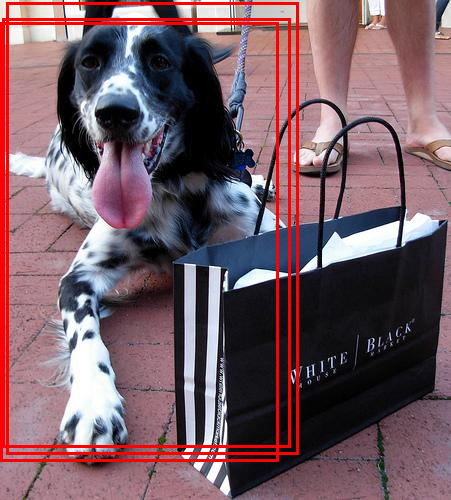

In [80]:
import torch, torchvision
from PIL import Image, ImageDraw
from torchvision.transforms import functional as F
import random, os, json

device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.detection.ssd300_vgg16(
    weights=None,
    num_classes=121
)
model.load_state_dict(torch.load("/content/ssd_dogs.pth", map_location=torch.device('cpu')))
model.eval().to(device)

val=json.load(open("/content/val.json"))
images=val["images"]

# pick random image
sample=random.choice(images)
img_path=os.path.join("/content/dogs/StanfordDogs/Images", sample["file_name"])
img=Image.open(img_path).convert("RGB")

with torch.no_grad():
    out=model([F.to_tensor(img).to(device)])[0]

draw=ImageDraw.Draw(img)
for box,score,label in zip(out["boxes"],out["scores"],out["labels"]):
    if score<0.5: continue
    x1,y1,x2,y2=box.cpu().numpy()
    draw.rectangle([x1,y1,x2,y2], outline="red", width=3)
img

Generates a dedicated evaluation script that runs inference
over the entire validation set and computes official COCO metrics
(AP, AP50, AP75, AR) using pycocotools.

In [64]:
%%writefile eval_coco.py
import argparse, json, torch, torchvision, os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from torchvision.transforms import functional as F

@torch.no_grad()
def run_eval(ann, images_dir, weights, device):
    print("Loading annotations...")
    coco = COCO(ann)
    img_ids = list(coco.imgs.keys())

    print("Loading model...")
    model = torchvision.models.detection.ssd300_vgg16(
    weights=None,
    num_classes=121
    )
    model.load_state_dict(torch.load(weights, map_location=device))
    model.to(device).eval()

    print("Running inference...")
    results = []

    for img_id in img_ids:
        info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(images_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        tensor = F.to_tensor(img).to(device)
        pred = model([tensor])[0]

        # Accept ALL predictions, even low score
        if len(pred["boxes"]) == 0:
            continue

        for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
            x1, y1, x2, y2 = box.tolist()
            results.append({
                "image_id": img_id,
                "category_id": int(label.item()),
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "score": float(score.item())
            })

    # Save predictions
    with open("predictions.json", "w") as f:
        json.dump(results, f)

    # If no predictions → return zeros
    if len(results) == 0:
        print("\n⚠️ WARNING: No predictions found!")
        print("Your model likely didn't learn enough yet.\n")
        print("Returning zero metrics:")
        print("mAP: 0.0\nAP50: 0.0\nAP75: 0.0\n")
        return

    # Patch COCO file
    if "info" not in coco.dataset:
        coco.dataset["info"] = {}
    if "licenses" not in coco.dataset:
        coco.dataset["licenses"] = []

    print("Running COCO evaluation...")
    coco_dt = coco.loadRes("predictions.json")

    ev = COCOeval(coco, coco_dt, iouType="bbox")
    ev.evaluate()
    ev.accumulate()
    ev.summarize()

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--ann")
    ap.add_argument("--images")
    ap.add_argument("--weights")
    ap.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
    args = ap.parse_args()

    run_eval(args.ann, args.images, args.weights, args.device)


Overwriting eval_coco.py


Runs full COCO evaluation using the trained model, producing official detection metrics such as AP@0.50:0.95 and AR at various detection thresholds.

In [65]:
! python eval_coco.py \
  --ann /content/val.json \
  --images /content/dogs/StanfordDogs/Images \
  --weights /content/ssd_dogs.pth

Loading annotations...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model...
Running inference...
Running COCO evaluation...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.60s).
Accumulating evaluation results...
DONE (t=1.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.584
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

Reads the CSV training log and generates PDF plots showing total loss and the classification versus bounding-box regression loss components over training.


In [66]:
!python plot_logs.py \
  --csv /content/logs/ssd_train.csv \
  --loss_pdf /content/plots/loss.pdf \
  --loss_components_pdf /content/plots/loss_components.pdf \




Load the training log CSV file and display its first few rows
to verify that loss, classification loss, bounding box loss,
learning rate, and iteration tracking were recorded correctly.
This also provides a quick sanity check before generating plots.


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV log
log_path = "/content/logs/ssd_train.csv"   # <-- change this
df = pd.read_csv(log_path)

print(df.head())


           time  epoch  iter        loss  classification  bbox_regression  \
0  1.764887e+09      1     1  144.886047      135.873932         9.012110   
1  1.764887e+09      1     2  127.343826      121.177811         6.166014   
2  1.764887e+09      1     3  171.690887      157.905792        13.785102   
3  1.764887e+09      1     4  168.582733      159.890289         8.692438   
4  1.764887e+09      1     5  217.661377      197.335831        20.325539   

       lr  
0  0.0001  
1  0.0001  
2  0.0001  
3  0.0001  
4  0.0001  


This visualization displays the total training loss over iterations to confirm convergence behavior and training stability.


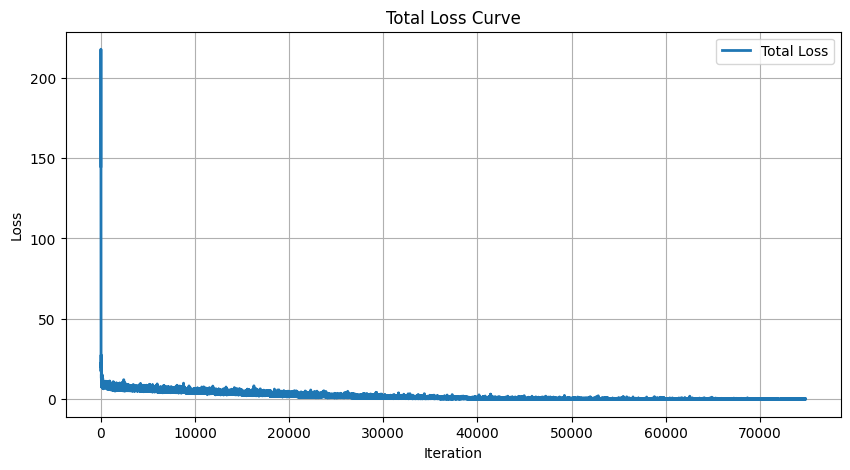

In [68]:
plt.figure(figsize=(10,5))
plt.plot(df["loss"], label="Total Loss", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Total Loss Curve")
plt.grid(True)
plt.legend()
plt.savefig("loss_curve.pdf")
plt.show()


This visualization displays the classification training loss over iterations to confirm convergence behavior and training stability.


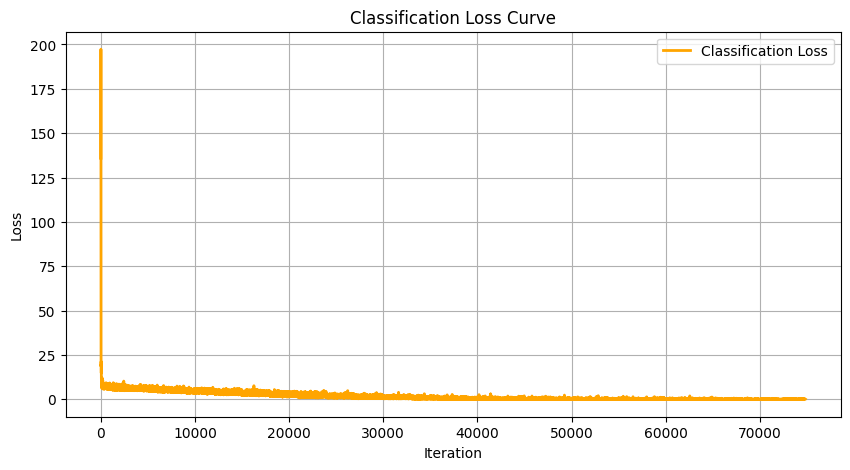

In [70]:
plt.figure(figsize=(10,5))
plt.plot( df["classification"], label="Classification Loss", linewidth=2, color='orange')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Classification Loss Curve")
plt.grid(True)
plt.legend()
plt.savefig("classification_loss.pdf")
plt.show()


Aggregates loss per training epoch and plots the mean loss trend over time, providing a high-level view of network convergence across training epochs.

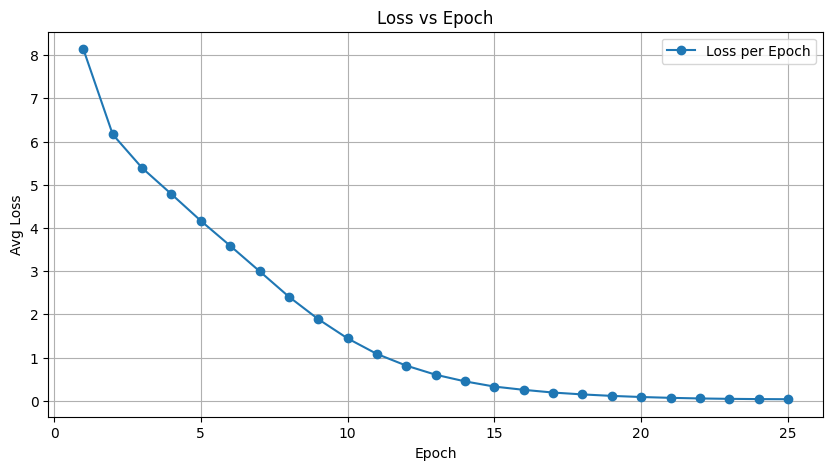

In [71]:
df_epoch = df.groupby("epoch").mean()

plt.figure(figsize=(10,5))
plt.plot(df_epoch.index, df_epoch["loss"], marker="o", label="Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.savefig("loss_epoch.pdf")
plt.show()


Displays raw noisy training loss (scatter)
with a smoothed rolling average curve (200-step window)
to better visualize overall learning trends.


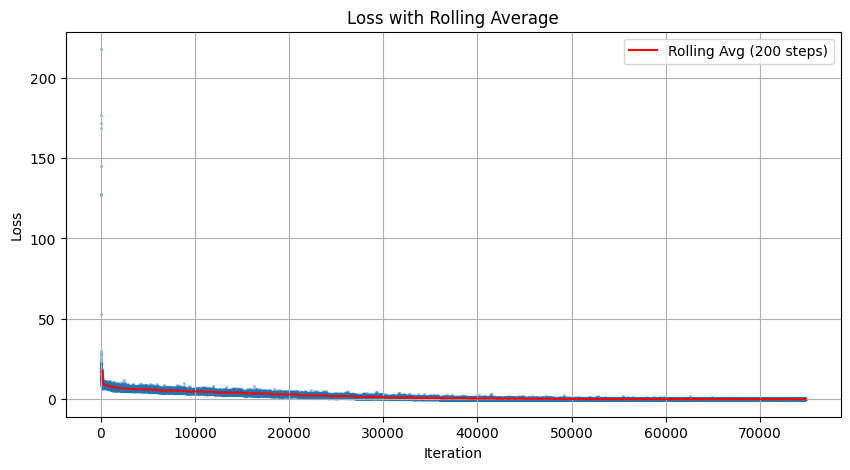

In [72]:
plt.figure(figsize=(10,5))
plt.scatter((df['epoch']-1) *2994+df["iter"], df["loss"], s=2, alpha=0.3)
plt.plot( df["loss"].rolling(200).mean(), color="red", label="Rolling Avg (200 steps)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss with Rolling Average")
plt.grid(True)
plt.legend()
plt.savefig("loss_rolling.pdf")
plt.show()


Plots the evolution of total loss, classification loss, and bounding-box
regression loss over training iterations using the logged CSV metrics.
This visualizes convergence behavior and the balance between localization
and classification learning in RetinaNet.

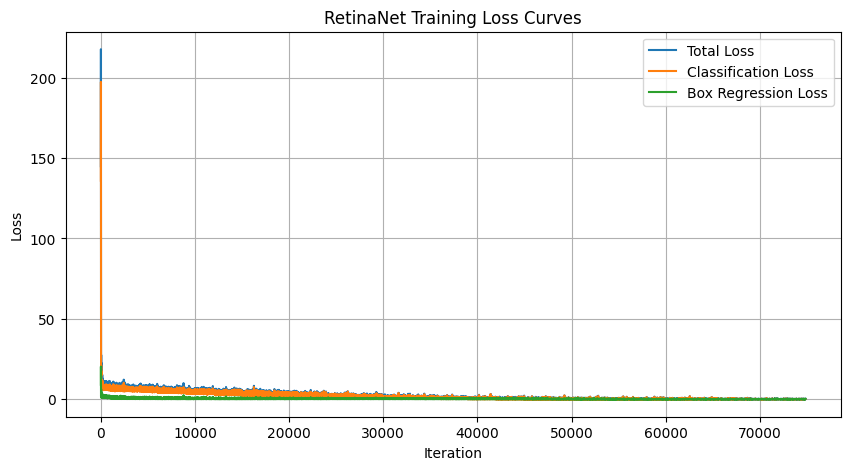

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/logs/ssd_train.csv")

plt.figure(figsize=(10,5))
plt.plot(df["loss"], label="Total Loss")
plt.plot(df["classification"], label="Classification Loss")
plt.plot(df["bbox_regression"], label="Box Regression Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("RetinaNet Training Loss Curves")
plt.legend()
plt.grid()
plt.savefig("loss_curve.pdf")
plt.show()


Run a full offline evaluation pipeline computing:
  - Per-class confusion matrix using IoU matching,
  - Precision–Recall curves over detection confidence,
  - Visualizations saved to PDF for report inclusion.

 This provides deeper insight beyond COCO summary metrics.

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Computing confusion matrix...


100%|██████████| 1996/1996 [01:09<00:00, 28.86it/s]


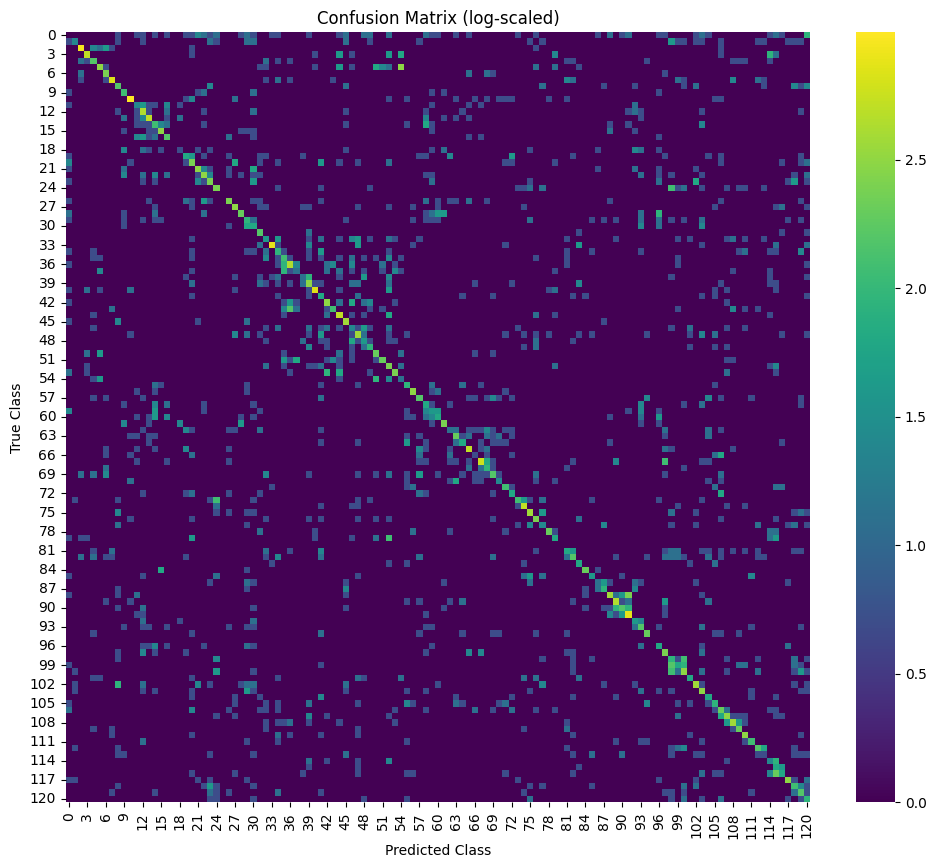

Computing precision–recall curve...


100%|██████████| 1996/1996 [01:07<00:00, 29.43it/s]


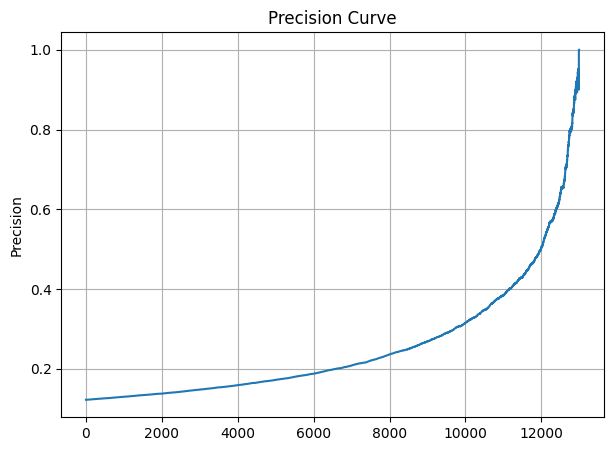

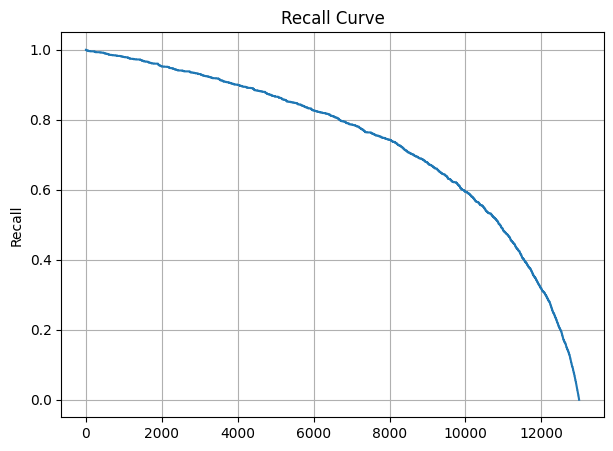

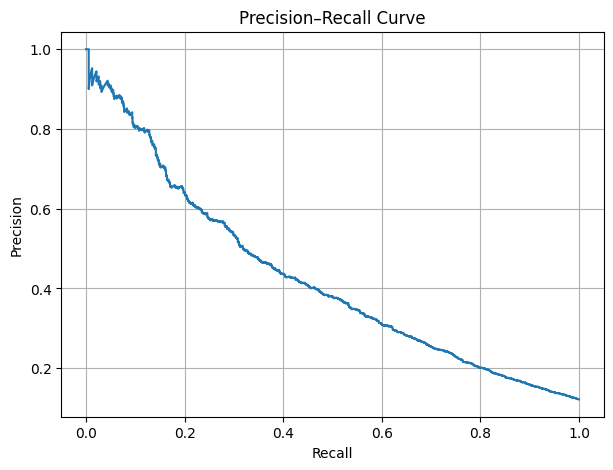

Saved: confusion_matrix.png, precision_recall_curve.png


In [74]:
import torch
import torchvision
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to sys.path to allow importing local modules
sys.path.append(os.getcwd())

from dogs_coco_dataset import DogsCocoDet, collate_fn
from pycocotools.coco import COCO
import tqdm

def load_model(weights, num_classes=121, device="cuda"):
    model = torchvision.models.detection.ssd300_vgg16(
    weights=None,
    num_classes=121
    )
    model.load_state_dict(torch.load(weights, map_location=device))
    model.to(device)
    model.eval()
    return model

# --------------------------------------------------
# Compute per-class confusion matrix
# --------------------------------------------------
def compute_confusion(model, dataset, device="cuda", iou_thresh=0.5):
    all_gt = []
    all_pred = []
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    for imgs, targets in tqdm.tqdm(loader):
        img = imgs[0].to(device)
        gt_boxes = targets[0]["boxes"].cpu().numpy()
        gt_labels = targets[0]["labels"].cpu().numpy()

        with torch.no_grad():
            pred = model([img])[0]

        pred_boxes = pred["boxes"].cpu().numpy()
        pred_labels = pred["labels"].cpu().numpy()
        scores = pred["scores"].cpu().numpy()

        # Filter weak predictions
        keep = scores > 0.5
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]

        if len(pred_boxes) == 0:
            # All GT become false negatives
            all_gt.extend(gt_labels)
            all_pred.extend([0]*len(gt_labels))  # 0 = background
            continue

        # IoU matching
        ious = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))
        for p_idx in range(len(pred_boxes)):
            max_iou, g_idx = torch.max(ious[p_idx], dim=0)
            if max_iou > iou_thresh:
                all_gt.append(int(gt_labels[g_idx]))
                all_pred.append(int(pred_labels[p_idx]))
            else:
                # False positive
                all_gt.append(0)
                all_pred.append(int(pred_labels[p_idx]))

    # Compute confusion matrix (121 classes incl background)
    cm = confusion_matrix(all_gt, all_pred, labels=list(range(121)))
    return cm

# --------------------------------------------------
# Compute precision–recall curve for the detector
# --------------------------------------------------
def compute_precision_recall(model, dataset, device="cuda"):
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    y_true = []
    y_scores = []

    for imgs, targets in tqdm.tqdm(loader):
        img = imgs[0].to(device)
        gt_labels = targets[0]["labels"].cpu().numpy()

        with torch.no_grad():
            pred = model([img])[0]

        scores = pred["scores"].cpu().numpy()
        labels = pred["labels"].cpu().numpy()

        for s, l in zip(scores, labels):
            y_scores.append(s)
            y_true.append(1 if l in gt_labels else 0)

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    return precision, recall, thresholds

# --------------------------------------------------
# Plot utils
# --------------------------------------------------
def plot_confusion(cm, out="confusion_matrix.pdf"):
    import seaborn as sns
    plt.figure(figsize=(12, 10))
    sns.heatmap(np.log1p(cm), cmap="viridis")
    plt.title("Confusion Matrix (log-scaled)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()

def plot_pr_curve(precision, out="precision_curve.pdf"):
    plt.figure(figsize=(7,5))
    plt.plot(precision)
    # plt.xlabel("Precision")
    plt.ylabel("Precision")
    plt.title("Precision Curve")
    plt.grid(True)
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()

def plot_re_curve( recall, out="recall_curve.pdf"):
    plt.figure(figsize=(7,5))
    plt.plot(recall)
    # plt.xlabel("Recall")
    plt.ylabel("Recall")
    plt.title("Recall Curve")
    plt.grid(True)
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()

def plot_pre_curve(precision, recall, out="precision_recall_curve.pdf"):
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.grid(True)
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()


if __name__ == "__main__":
    import argparse
    # Remove the -f argument added by the Jupyter kernel if present
    if "-f" in sys.argv:
        # Find the index of '-f'
        f_index = sys.argv.index("-f")
        # Remove '-f' and its value (the connection file path)
        sys.argv.pop(f_index)
        sys.argv.pop(f_index) # The index is the same after the first pop

    ap = argparse.ArgumentParser()
    ap.add_argument("--images", default="/content/dogs/StanfordDogs/Images")
    ap.add_argument("--ann", default="/content/val.json")
    ap.add_argument("--weights", default="/content/ssd_dogs.pth")
    args = ap.parse_args()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    ds = DogsCocoDet(args.images, args.ann)

    model = load_model(args.weights, device=device)

    print("Computing confusion matrix...")
    cm = compute_confusion(model, ds, device=device)
    np.save("confusion.npy", cm)
    plot_confusion(cm)

    print("Computing precision–recall curve...")
    precision, recall, thresholds = compute_precision_recall(model, ds, device=device)
    plot_pr_curve(precision)
    plot_re_curve(recall)
    plot_pre_curve(precision, recall)

    print("Saved: confusion_matrix.png, precision_recall_curve.png")